<a href="https://colab.research.google.com/github/AdamVinestock/Computer-Vision/blob/main/HoughTransform_RANSAC_3DfromStereo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <span style="color:blue"> Computer Vision - Winter 2024

## <span style="color:blue"> Exercise 2 </span>
**Reichman University**

**Lecturer:** Prof. Yael Moses, RUNI

**TA:** Eyal Friedman, RUNI

In this exercise, you will implement:
    
1. Straight line detection from image features using  Hough Transform.
2. Various feature matching.
3. Computing depth from rectified images.





In [ ]:
import cv2 as cv2
from scipy.signal import convolve2d
import copy


from matplotlib import pyplot as plt

# This opens an inteactive figure - use it in part B
import matplotlib
# matplotlib.use('TkAgg')
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space

# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.10.12
Numpy version:  1.23.5




## <span style="color:blue">Section A: Detect a Straight Lines

In this part you will use the set of edge points to detect straight lines in an image.\
The input will consist of edge points computed by the Canny edge detector - you can use the implementation of CV2, which is demonstrated below.\
    The output will be a set of straight lines in the image. There are two main methods to compute straight lines from such input: the Hough transform and RANSAC. You will implement the Hough transform.

    

**Hough transform**\
Every 2D line, $\ell$,   can be represented by 2 parameters:  $r$ and $\theta$ where all points on the lines satisfy $r=(xcos\theta, ysin\theta)$.
Let $P_0=(x_0,y_0)$ be the intersection of a normal to $\ell$ from the origin.
The distance between $P_0$ and the origin is given by $r$ and the angle between the normal and the $x$ axis is given by $\theta$.






**Your goal:**     Write the following function\
Straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)\
    You can add any other parameters that you need.
    


 To do so, you need also to define the following functions.
 You can add parameters to the functions, as long as you  provide clear explanations of their roles and purposes.

# Part A Answers

In [ ]:
# Input: a set of edge points (or corners), and the resolution of the distance and angles.
# output: the Hough matrix (H) containing votes for lines represented by r and θ.
def H_matrix(L_points, resolution_r, resolution_ang):

  max_dist = int(np.ceil(np.sqrt(np.max([x**2 + y**2 for x, y in L_points]))))
  theta = np.deg2rad(np.arange(-180, 180, resolution_ang))
  theta_idx = np.arange(len(theta))
  r = np.arange(0, 2*max_dist, resolution_r)
  H = np.zeros((len(r), len(theta)), dtype=np.int64)

  cos_t = np.cos(theta)
  sin_t = np.sin(theta)


  for x, y in L_points:                                     # Assuming L_points is a list of (x,y) edge points
    r_vals = x * cos_t + y * sin_t                          # Calculate r values for all thetas
    r_idx = np.round(r_vals / resolution_r).astype(int)     # Convert r values to respective index input

    for ri, ti in zip(r_idx, theta_idx):
      if 0 <= ri < len(r) and 0 <= ti < len(theta):
        H[ri, ti] += 1

  return H


# Input: The Hough matrix H, and a threshold for the number of minimal points on the line.
# output a list of triplets:  (r, \Theta, num_points) where
# num_points is the number of points on that line.
def list_lines(H, th, resolution_r, resolution_ang):
    new_H = np.where(H>th, H, 0)
    lines_list = []
    r_vals = np.arange(0, H.shape[0]) * resolution_r
    theta_vals = np.deg2rad(np.arange(-180, 180, resolution_ang))
    for i in range(H.shape[0]):
      for j in range(H.shape[1]):
        if new_H[i,j]>0 :
          lines_list.append(tuple((r_vals[i], theta_vals[j], new_H[i,j])))

    return lines_list

# Display the detected lines in red - overlaid the original image
# Note: one way to do is, is to add the red lines to the image, and then display it
def display_lines(im,list_lines):

  lined_image = np.copy(im)
  lined_image = np.dstack([lined_image,lined_image,lined_image])   # a gray level image that is saved as a color image

  for r, theta, _ in list_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = int(a * r)
    y0 = int(b * r)

    x1 = int(x0 + 1500 * (-b))
    y1 = int(y0 + 1500 * (a))
    x2 = int(x0 - 1500 * (-b))
    y2 = int(y0 - 1500 * (a))
    lined_image = cv2.line(lined_image, (x1, y1), (x2, y2), (0, 0, 255), 1)

  lined_image_rgb = cv2.cvtColor(lined_image, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(8, 8))
  plt.imshow(lined_image_rgb)
  plt.show()

  return

In [ ]:
def List_of_edges(img, canny):

  T_lower,  T_upper, aperture_size = canny
  edges = cv2.Canny(img,T_lower,T_upper,aperture_size)
  L_edges = []
  for i in range(edges.shape[0]):
    for j in range(edges.shape[1]):
      if edges[i,j] != 0:
        L_edges.append((j,i))           # edge tuple is (x,y) where x is  horizontal axis and y is vertical axis of the image

  return L_edges

def straight_lines(image_path, res_r, res_orient, min_number_points, canny_params, display =1):

  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  L_edges = List_of_edges(img,canny_params)
  H = H_matrix(L_edges, res_r, res_orient)
  L_lines = list_lines(H,min_number_points, res_r, res_orient)

  if display == 1 :
    display_lines(img,L_lines)

  return

**Apply and answer**

1. Generate a synthetic image to test your Hough Transform algorithm.
   * Submit the image as well as the results.


2. Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku.
   * Choose a set of parameters so the results looks fine.
   * You may need different parameters for each image.
   * Display the results.
   
   
3. **Answer**: How the resolutions of $r$ and $\theta$ affect the results?
   * Display images that demonstarte your answer.
   
   
4. Choose one image and **answer**: how many straight lines did you find with more than 50 points?
   * Display these lines on the image.
   
   
5. Suggest an algorithm to compute the length of the line in the image.
   * Describe the algorithm without implementing it.
   
   
6. Suggest three applications to use the results of straight line detection in an image.



### **Question 1:**

Generate a synthetic image to test your Hough Transform algorithm.

Submit the image as well as the results.

Crosswalk image with r_res = 2 , theta_res = 5, min_num_edges = 100


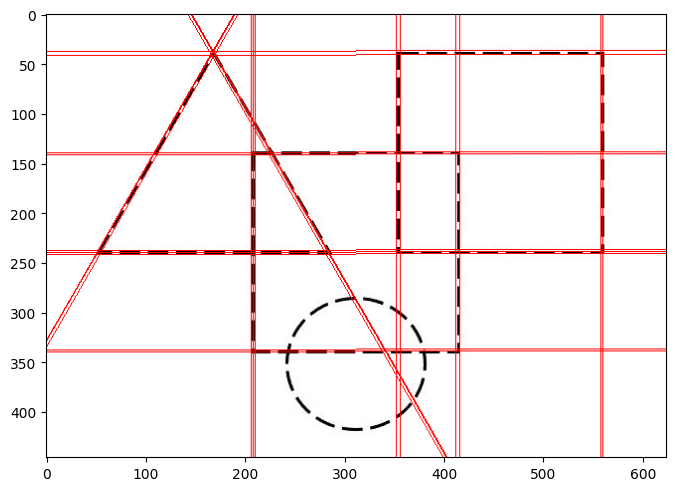

In [ ]:
# Generate a synthetic image to test your Hough Transform algorithm.
# Submit the image as well as the results.


r_res = 2
theta_res = 5
min_num_edges = 100

print(f'Crosswalk image with r_res = {r_res} , theta_res = {theta_res}, min_num_edges = {min_num_edges}')
canny_params = (250,500,5)
straight_lines('/content/synthetic_image.jpeg', r_res, theta_res, min_num_edges,canny_params, display =1)


### **Question 2:**

Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku.

*  Choose a set of parameters so the results looks fine.
*  You may need different parameters for each image.
*  Display the results.





(<matplotlib.image.AxesImage at 0x7dc66fdb1720>, Text(0.5, 1.0, 'Edge Image'))

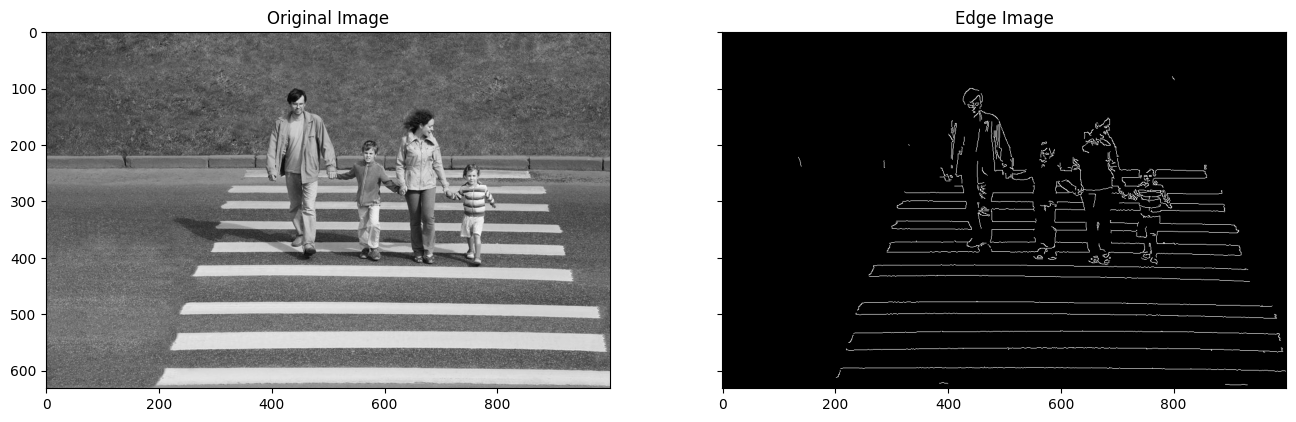

In [ ]:
img = cv2.imread('/content/Crosswalk.jpg', cv2.IMREAD_GRAYSCALE)

assert img is not None, "file could not be read, check with os.path.exists()"

edges = cv2.Canny(img,250,500,5)

plt.rcParams['figure.figsize'] = (16.0, 16.0)
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')

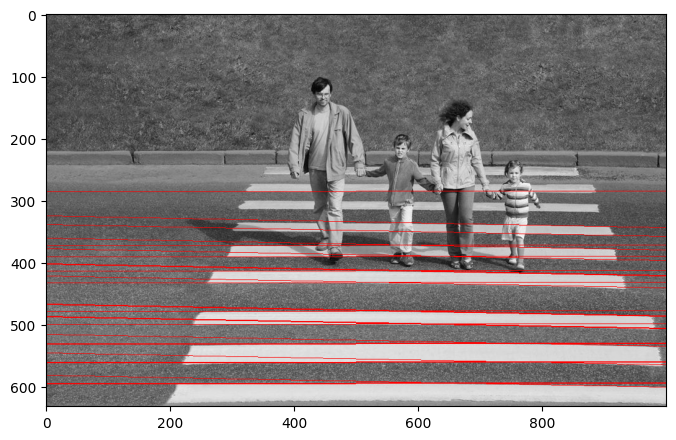

CPU times: user 8.13 s, sys: 192 ms, total: 8.32 s
Wall time: 10.3 s


In [ ]:
%%time
canny_params = (250,500,5)
straight_lines('/content/Crosswalk.jpg', 1, 1, 150,canny_params, display =1)

(<matplotlib.image.AxesImage at 0x7dc66f916aa0>, Text(0.5, 1.0, 'Edge Image'))

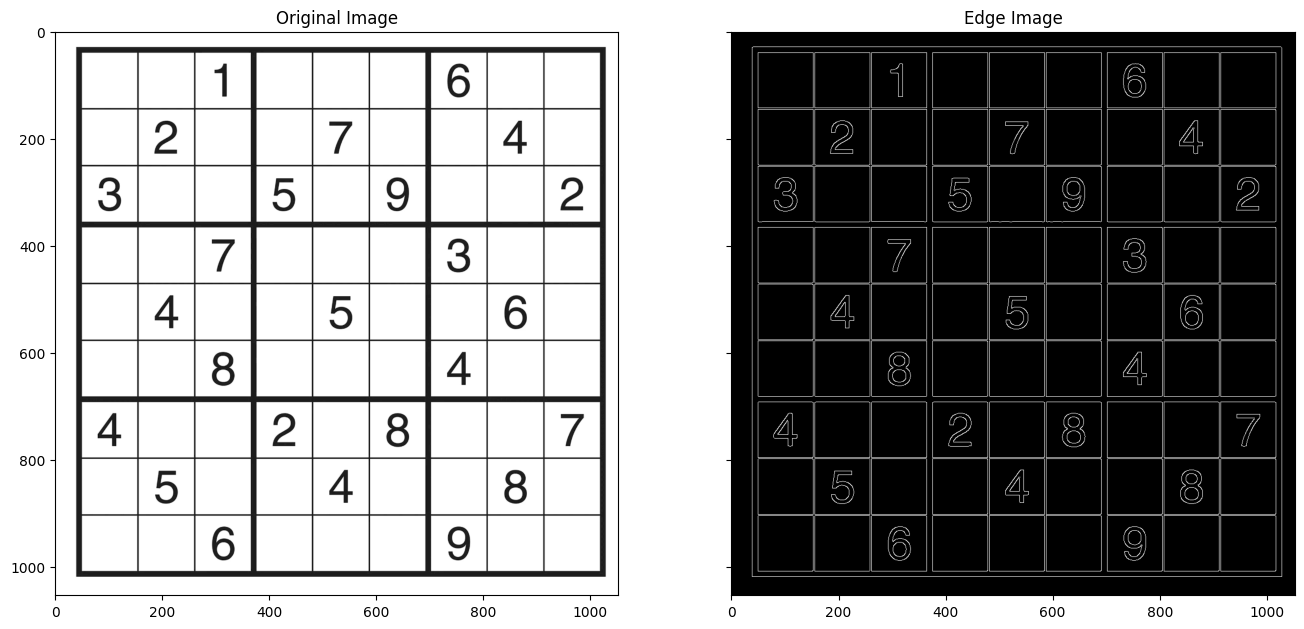

In [ ]:
img = cv2.imread('/content/Sudoku.PNG', cv2.IMREAD_GRAYSCALE)

assert img is not None, "file could not be read, check with os.path.exists()"

edges = cv2.Canny(img,250,500,5)

plt.rcParams['figure.figsize'] = (16.0, 16.0)
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')


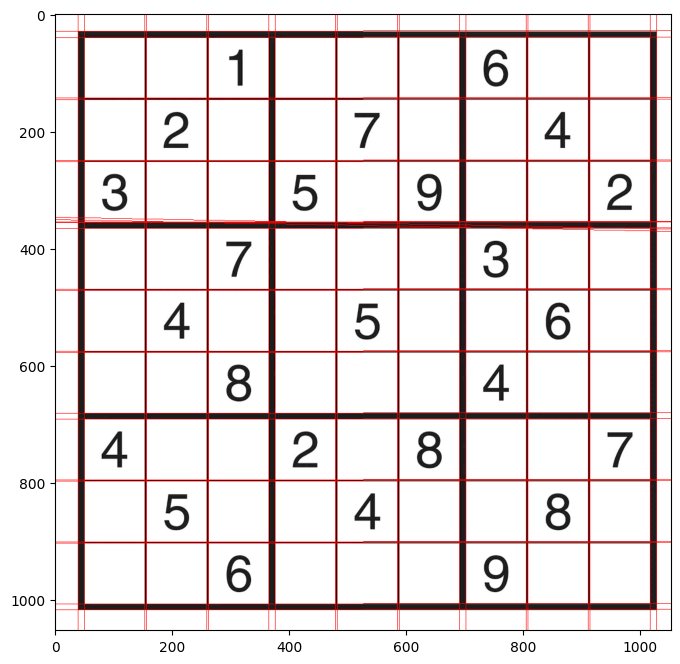

In [ ]:
canny_params = (250,500,5)
straight_lines('/content/Sudoku.PNG', 1, 1, 150, canny_params,display = 1)

(<matplotlib.image.AxesImage at 0x7dc66f8c03d0>, Text(0.5, 1.0, 'Edge Image'))

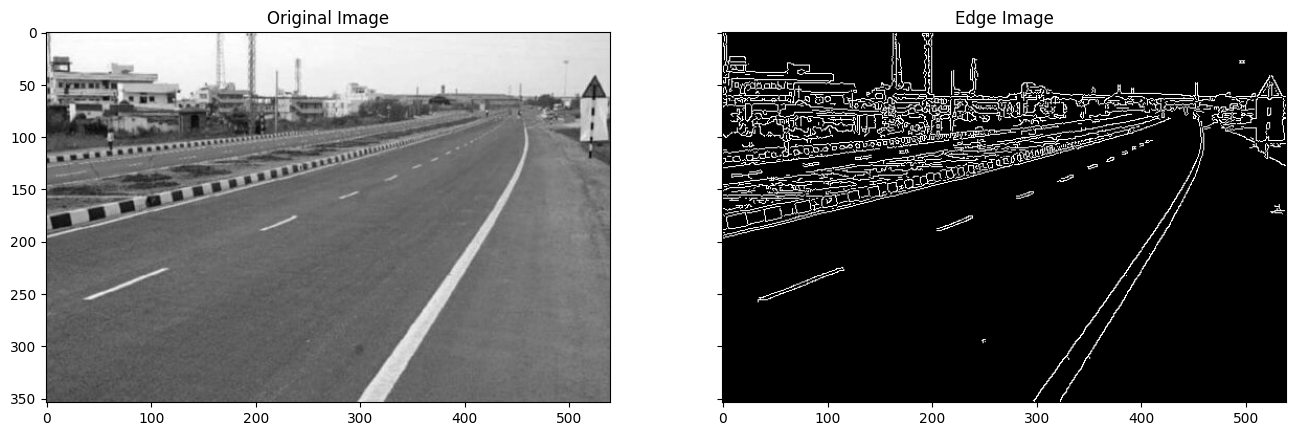

In [ ]:

img = cv2.imread('/content/linesOnTheRoadGray.jpg', cv2.IMREAD_GRAYSCALE)

assert img is not None, "file could not be read, check with os.path.exists()"

edges = cv2.Canny(img,50,150,5)

plt.rcParams['figure.figsize'] = (16.0, 16.0)
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')

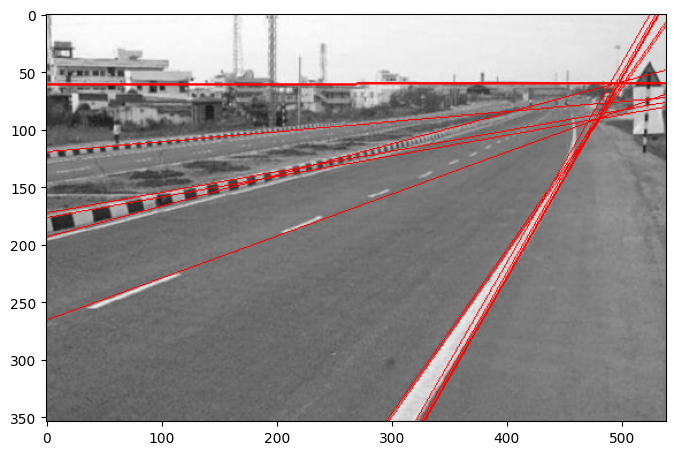

CPU times: user 1.02 s, sys: 130 ms, total: 1.15 s
Wall time: 1.03 s


In [ ]:
%%time
canny_params = (250,500,5)
straight_lines('/content/linesOnTheRoadGray.jpg', 1, 5, 50, canny_params,display =1)



### **Question 3**:###

**How the resolutions of  𝑟  and  𝜃  affect the results?**

**Display images that demonstarte your answer.**





Test no.1
Crosswalk image with r_res = 1 , theta_res = 1, min_num_edges = 150


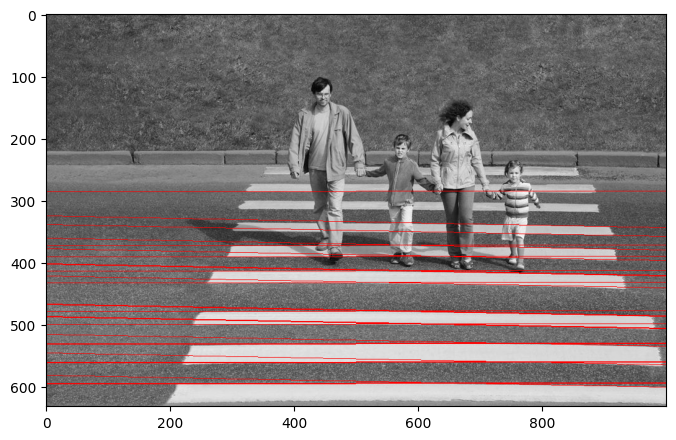

CPU times: user 5.65 s, sys: 208 ms, total: 5.86 s
Wall time: 5.69 s


In [ ]:
%%time

r_res = 1
theta_res = 1
min_num_edges = 150

print("Test no.1")
print(f'Crosswalk image with r_res = {r_res} , theta_res = {theta_res}, min_num_edges = {min_num_edges}')
canny_params = (250,500,5)
straight_lines('/content/Crosswalk.jpg', r_res, theta_res, min_num_edges,canny_params, display =1)



Test no.2
Crosswalk image with r_res = 3 , theta_res = 5, min_num_edges = 150


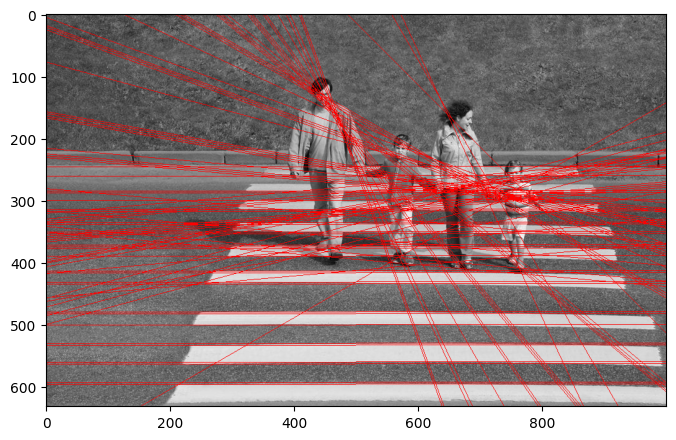

CPU times: user 2.76 s, sys: 166 ms, total: 2.93 s
Wall time: 2.8 s


In [ ]:
%%time

r_res = 3
theta_res = 5
min_num_edges = 150 # 220
print("Test no.2")
print(f'Crosswalk image with r_res = {r_res} , theta_res = {theta_res}, min_num_edges = {min_num_edges}')
canny_params = (250,500,5)
straight_lines('/content/Crosswalk.jpg', r_res, theta_res, min_num_edges,canny_params, display =1)

Test no.3
Crosswalk image with r_res = 3 , theta_res = 5, min_num_edges = 220


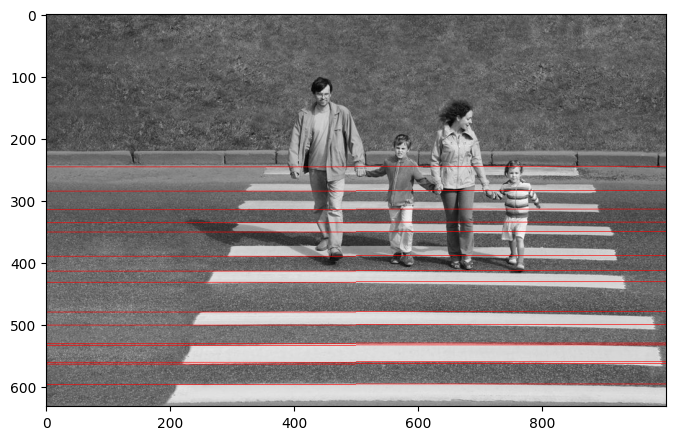

CPU times: user 3.69 s, sys: 152 ms, total: 3.84 s
Wall time: 3.85 s


In [ ]:
%%time

r_res = 3
theta_res = 5
min_num_edges = 220
print("Test no.3")
print(f'Crosswalk image with r_res = {r_res} , theta_res = {theta_res}, min_num_edges = {min_num_edges}')
canny_params = (250,500,5)
straight_lines('/content/Crosswalk.jpg', r_res, theta_res, min_num_edges,canny_params, display =1)

A higher resolution of θ and r allows for more precise detection of the angle of the lines in the image and their distance from the origin. This means lines that are at a slight angle or distance from each other can be distinguished more easily. On the other hand, a finer resolution can make the detection more sensitive to noise, as slight variations or noise in the image can result in the detection of multiple similar lines with slightly different angles.

When we started with the smallest values of θ and r, we received multiple lines on the same edges because the algorithm is very sensitive (test no.1). Then, after increasing the θ and r values, we expected that more lines would be detected (test no.2). However, it detected many 'false positive' lines because now there are more lines in each 'resolution bucket', so many more lines pass the 'minimum number of lines' criterion. For this reason, we increased the minimum number of lines from 150 to 220, and received the best results (test no.3).a

### **Question 4:** ###

**Choose one image and answer: how many straight lines did you find with more than 50 points?**

Display these lines on the image.

Crosswalk image with r_res = 1 , theta_res = 1, min_num_edges = 50


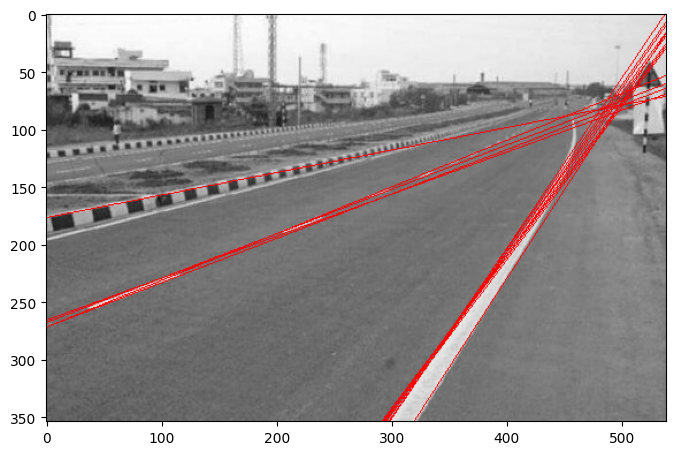

number of lines with minimum of 50 egdes = 1238


In [ ]:
r_res = 1
theta_res = 1
min_num_edges = 50

print(f'Crosswalk image with r_res = {r_res} , theta_res = {theta_res}, min_num_edges = {min_num_edges}')

# Notice that we changes the canny parameters in order to make the visulaition more understandable.
# However, it directly affected the number of lines that were detected.

canny_params = (400,500,5)
L_lines = List_of_edges(img, canny_params)
straight_lines('/content/linesOnTheRoadGray.jpg', r_res, theta_res, min_num_edges,canny_params, display =1)

print(f'number of lines with minimum of 50 egdes = {len(L_lines)}')




We selected the 'linesOnTheRoadGray' image to evaluate how many lines were detected with a minimum of 50 edges and a  and r values of 1. The result was 1,238.

### **Question 5:** ###

**Suggest an algorithm to compute the length of the line in the image.**

Describe the algorithm without implementing it:

**Answer:** An algorithm to compute the length of the line in the image:

1. Run an edge detection algorithm, such as the Canny edge detector, to identify the edges in the image.

2. Compute the Hough Transform with the following modification:

  *  For each entry in the Hough Matrix (representing a potential line in the image), maintain two additional variables - min_x and max_x. Update these values during the processing of Hough Matrix.

  *   min_x and max_x represent the edge points with the minimum and maximum x-coordinates, respectively, among all edge points that lie on the same line, characterized by the same theta and r values in the Hough space.

3. For each line (represented by a pair of r and theta values) that meets a predefined threshold of number edge points, draw the line segment between min_x and max_x.





### **Question 6:**



**Suggest three applications to use the results of straight line detection in an image:**

1. Autonomous Navigation - straight line detection could be beneficial for lane detection and lane keeping in autonomous vehicles.

2. Bar code scanning - one could use line detectors to compute barcode frequency for scanned items.

3. Applications designed for document scanning can utilize straight line detection to identify the edges of pages, ensuring an accurate and well-aligned scan or crop.


# <span style="color:blue">Section B: Patch Matching
**In this part you will match intrest points between two images.**
    
    
There are two functions between vectors $v$ and $u$ that you will consider:\
a. Distance: Sum of Square Distance (SSD). That is,  $SSD(u,v)=(u-v)\cdot(u-v)$.\
b. Similarity: Normalized Cross Correlation (NCC). That is,  $NCC(u,v)={u\cdot v \over ||u||||v||}$.


The patch descriptor:
1. A vector with the pixels' grey level.
2. An histogram (30 bins) of the pixels' grey level.
3. A vector with the pixels' strength gradient.
4. An histogram (30 bins) of the pixels' strength of gradient.


In [ ]:
#Implement the following functions:

# Input: two vectors
# Output distance (scalar) between two patches

def SSD(patch_descr_1, patch_descr_2):
  u = patch_descr_1
  v = patch_descr_2
  u_v = u - v
  return (u_v @ u_v.T)

# Input: two vectors
# Output normalized cross correlation (scalar) between two patches

def NCC(patch_descr_1, patch_descr_2):
  u = patch_descr_1
  v = patch_descr_2
  u_norm = np.linalg.norm(u, axis = 1)
  v_norm = np.linalg.norm(v, axis = 1)
  u_norm_reshaped = u_norm[:, np.newaxis]
  v_norm_reshaped = v_norm[:, np.newaxis]

  # Normalize each row in u and v
  u_normalized = u / u_norm_reshaped
  v_normalized = v / v_norm_reshaped
  return np.dot(u_normalized,v_normalized.T)

# Output a descriptor vector
# im is an image, p is a pixel, size is the patch size.
# You can use the histogram function of open cv or numpy

def patch_from_im(im,p,size):
  half_size = size // 2
  start_x = p[0] - half_size
  end_x = p[0] + half_size
  start_y = p[1] - half_size
  end_y = p[1] + half_size
  patch = im[start_x : end_x+1, start_y : end_y+1]
  return patch

def hist_patch_im(im,p,size):
  patch = patch_from_im(im, p, size)
  hist = cv2.calcHist([patch], [0], None, [30], [0, 256])
  return hist

def gradient(im,p,size):
  patch = patch_from_im(im, p, size)
  grad_x = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=5)
  grad_y = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=5)
  grad = cv2.magnitude(grad_x, grad_y)
  return grad

def hist_gradient(im,p,size):
  grad = gradient(im, p, size)
  hist = cv2.calcHist([grad], [0], None, [30], [0, 256])
  return hist

**Apply and answer**


1. Compute the corners in a pair of images (e.g., view0.tif and view6.tif).


2. Choose up to 2000 of the strongest corners (you can use fewer) and find a matching between the corners in the pair of images.
    * Choose a fixed scale and use it to define a patch around each corner.
    * To display the matching, use the function cv2.hconcat([im1, im2]), which concatenates two images horizontally, and then draw lines as described in the previous section.


3. Use up to 4000 of the strongest corners (you can use fewer) in each image and use the matching only between corners that have approximately the same y-coordinate (up to a threshold).


4. Study the ratio for matching between the best and the second best match.
   * You can use NCC or SSD on the desriptor of your choice.
   * You can use without (2) or with (3) the $y$-coordinate constraint.
   * **Present** examples that demonstrate the effectiveness of using the ratio.


5. Study the differences between the different descriptors and also the use of SSD or NCC.
   * **Present**  examples that demonstrate your findings.


6. Identify incorrect pairs of matched points.\
   **Mark and display** for cases (2), (3), and (4) a pair of incorrectly matched points.\
   **Answer**\
   a. In which of the 3 cases are there more incorrect matches?\
   b. What may be the reason for the incorrect matches?


7. In which regions of the scene were most of the reliable matches found?



**Implementation details**

You can compute the NCC or SSD patch by patch. This will probably takes longer than using matrix multiplications of numpy.

Using matrices:
1. Generate a 1D vector from each descriptor.


2. Generate a matrix $M_1$:  rows  are  the descriptors of img1.


3. Generate a matrix $M_2$:  columns  are  the descriptors of img2.


4. $M=np.matmul(M_1,M_2)$\
   * what is the value in $M(i,j)$?


5. Think of how to normalize the set of patches, if you need.
   * You can consider using the function np.diag(np.diag(matrix)) as part of your solution.
    
    

## Harris from HW1

In [ ]:
# The following code is our Harris Corners Detector from HW1.
# In the next cells of this notebook we will compare between the CV2 Harris and ours.

def Deriv_Gauss_xy(sig=1):

  kernel_size = 6 * sig + 1 # sig must be an integer
  x = np.linspace(-kernel_size/2, kernel_size/2, kernel_size) #array of x values
  y = np.linspace(-kernel_size/2, kernel_size/2, kernel_size) #array of y values
  x, y = np.meshgrid(x, y)  # Create a grid of points


  G_dx = (-x/(2*np.pi*sig**4))*np.exp(-(np.square(x) + np.square(y))/(2*sig**2))
  G_dy = (-y/(2*np.pi*sig**4))*np.exp(-(np.square(x) + np.square(y))/(2*sig**2))
  return G_dx , G_dy

def Grad_xy(img,sig):
  G_dx ,G_dy = Deriv_Gauss_xy(sig)

  I_x = convolve2d(img,G_dx, mode='same', boundary='fill', fillvalue=0)
  I_y = convolve2d(img,G_dy, mode='same', boundary='fill', fillvalue=0)

  return I_x, I_y


def Compute_Cq_components(I_x,I_y):
  I2_x = I_x * I_x # Elementwise multiplication
  I2_y = I_y * I_y # Elementwise multiplication
  I_x_y = I_y * I_x # Elementwise multiplication
  return I2_x, I2_y, I_x_y

def Gaussian(sig):

  kernel_size = 6 * sig + 1 # sig must be an integer
  x = np.linspace(-kernel_size/2, kernel_size/2, kernel_size) #array of x values
  y = np.linspace(-kernel_size/2, kernel_size/2, kernel_size) #array of y values
  x, y = np.meshgrid(x, y)  # Create a grid of points

  return (1/(2*np.pi*sig**2))*np.exp(-(np.square(x) + np.square(y))/(2*sig**2))


def Compute_Cij(I2_x,I2_y,I_x_y,sig_neighb):


  G_neihb = Gaussian(sig_neighb)

  C11 = convolve2d(I2_x,G_neihb, mode='same', boundary='fill', fillvalue=0)
  C22 = convolve2d(I2_y,G_neihb, mode='same', boundary='fill', fillvalue=0)
  C12 = convolve2d(I_x_y,G_neihb, mode='same', boundary='fill', fillvalue=0)

  return C11, C12, C22

def Compute_eigen_val_vec(C11, C12, C22):

  n_rows = C11.shape[0]
  n_columns = C11.shape[1]

  eigen_values_array = np.empty((n_rows,n_columns))
  eigen_vectors_array = np.empty((n_rows,n_columns,2,2))


  for i in range(n_rows):
    for j in range(n_columns):
      C_q = np.array([[C11[i,j], C12[i,j]],[C12[i,j], C22[i,j]]])
      eigenvalues, eigenvectors = np.linalg.eig(C_q)
      eigen_values_array[i,j] = min(eigenvalues)
      eigen_vectors_array[i,j] = eigenvectors

  return eigen_values_array, eigen_vectors_array

def Compute_thresh(eigen_values_array, th, img):
  new_img = np.where(eigen_values_array < th,0,255)
  return new_img

def non_maximum_suppression(img, eigen_values_array, density_size):
    height, width = img.shape
    diluted_corners_img = np.zeros_like(img)
    for y in range(0, height, density_size):
        for x in range(0, width, density_size):
            window = eigen_values_array[y:y+density_size, x:x+density_size]
            max_val = np.max(window)
            max_pos = np.unravel_index(np.argmax(window), window.shape)
            max_y, max_x = y + max_pos[0], x + max_pos[1]
            diluted_corners_img[max_y, max_x] = img[max_y, max_x]

    return diluted_corners_img

def H_corner(img, sig_smooth, sig_neighb, th, density_size, display=0):

  I_x, I_y = Grad_xy(img,sig_smooth)
  I2_x, I2_y, I_x_y = Compute_Cq_components(I_x,I_y)
  C11, C12, C22 = Compute_Cij(I2_x,I2_y,I_x_y,sig_neighb)
  eigen_values_array, eigen_vectors_array = Compute_eigen_val_vec(C11, C12, C22)
  threshed_img = Compute_thresh(eigen_values_array, th, img)
  diluted_corners_img = non_maximum_suppression(threshed_img, eigen_values_array, density_size)

  overlayed_corners_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  corners = []
  for i in range(diluted_corners_img.shape[0]):
    for j in range(diluted_corners_img.shape[1]):
      if diluted_corners_img[i,j]>0:
        corners.append((np.array([j,i]),diluted_corners_img[i,j]))
        overlayed_corners_img = cv2.circle(overlayed_corners_img, (j, i), 5, (255, 0, 0), 1)

  eigen_min_val = np.min(eigen_values_array)
  eigen_max_val = np.max(eigen_values_array)
  normalized_eigen_values = (eigen_values_array - eigen_min_val) / (eigen_max_val - eigen_min_val) * 255 # Normalize eigan values to 0-255
  normalized_eigen_values = normalized_eigen_values.astype(np.uint8)

  if display == 0:
    return corners

  elif display == 1:
    fig, axs = plt.subplots(3, 2, figsize=(12, 18))

    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(I_x, cmap='gray')
    axs[0, 1].set_title('I_x')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(I_y, cmap='gray')
    axs[1, 0].set_title('I_y')
    axs[1, 0].axis('off')

    axs[1, 1].imshow(normalized_eigen_values, cmap='gray')
    axs[1, 1].set_title('Before corner threshold')
    axs[1, 1].axis('off')

    axs[2, 0].imshow(threshed_img, cmap='gray')
    axs[2, 0].set_title('After corner threshold')
    axs[2, 0].axis('off')

    axs[2, 1].imshow(overlayed_corners_img)
    axs[2, 1].set_title('Corners overlayed on original image')
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

  elif  display == 2:
    print(f"sig_smooth: {sig_smooth}, sig_neighbor: {sig_neighb}, threshold: {th}, density_size: {density_size}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.imshow(overlayed_corners_img)
    ax2.set_title('Corners overlayed on original image')
    ax2.axis('off')
    plt.show()

  elif  display == 3:

    figsize=(12, 8)
    plt.imshow(overlayed_corners_img, cmap='gray')
    plt.title(f"sig_smooth: {sig_smooth}, sig_neighbor: {sig_neighb}, threshold: {th}, density_size: {density_size}")
    plt.axis('off')
    plt.show()

  elif display == 4:
    return overlayed_corners_img


We decided to use the CV2.HarrisCorners() because our Harris detector from HW1, was implemented as the non-vectorized form of the algorithm (which was allowed in HW1), making runtime of our implementation much larger. A key advantage of our method is the implementation of non_max_supression, making some results better.

## Part B Methods

In [ ]:
def is_patch_within_image(image, pixel, patch_size):
    height, width = image.shape[:2]
    half_patch_size = patch_size // 2  # Calculate half size of the patch

    # Calculate patch boundaries
    top_left_x = pixel[0] - half_patch_size
    top_left_y = pixel[1] - half_patch_size
    bottom_right_x = pixel[0] + half_patch_size
    bottom_right_y = pixel[1] + half_patch_size

    # Check if the patch is within the image boundaries
    if (top_left_x >= 0 and top_left_y >= 0 and
        bottom_right_x < width and bottom_right_y < height):
        return True
    else:
        return False

def detect_corners(img, num_corners, patch_size, dilate_flag = False , blockSize=1, ksize=1, k=0.08):
    #if our_harris == False:
    corners = cv2.cornerHarris(img, blockSize, ksize, k)
    # Dilate to mark the corners
    if dilate_flag == True:
      corners = cv2.dilate(corners, None)

    threshold = 0.01 * corners.max()
    corner_list = []
    for i in range(corners.shape[0]):
      for j in range(corners.shape[1]):
        if corners[i, j] > threshold:
          if is_patch_within_image(img,(i,j), patch_size):
            corner_list.append((np.array([j, i]),corners[i, j]))  # Note: (x, y) format
    #else:
     # corner_list =  H_corner(img, sig_smooth = 3, sig_neighb=2, th=1.5, density_size=15, display=0)

    sorted_list = sorted(corner_list, key = lambda x: x[1])
    resulted_list = sorted_list[0:num_corners]
    return resulted_list

def create_descriptors_matrix(corner_list1, corner_list2, img1, img2, patch_size, disc_type = "intensity"):
  """
  creates the descriptor matrix for each image [n_descriptor, descriptor_szie]
  desc_type can be intensity/hist/grad

  """
  descriptor_matrix1 = None
  descriptor_matrix2 = None
  # img1 = img1.astype(np.int64).copy()
  # img2 = img2.astype(np.int64).copy()

  lists_and_images = [(corner_list1,img1), (corner_list2,img2)] # item = tuple(corner_list, img)


  for item in lists_and_images:
    if disc_type == "hist":
      descriptor_matrix = np.zeros((len(item[0]),30 + 2))      # [n_descriptors , length of descriptor + 2 entries for the coordinates of each centered pixel]
    else:
      descriptor_matrix = np.zeros((len(item[0]),patch_size**2 + 2))
    for i, corner in enumerate(item[0]):

      # creating patch for corner pixel:
      patch = patch_from_im(item[1],corner[0], patch_size)

      # creating descriptor from the patch:
      if disc_type == "intensity":
        descriptor = patch.flatten()
      elif disc_type == "hist":
        descriptor = hist_patch_im(item[1],corner[0],patch_size).flatten()
      else:
        descriptor = gradient(item[1],corner[0],patch_size).flatten()

      stacked_descriptor = np.concatenate((descriptor,corner[0]))
      descriptor_matrix[i,:] = stacked_descriptor
    if item[1] is img1:
      descriptor_matrix1 = descriptor_matrix
    else:
      descriptor_matrix2 = descriptor_matrix

  return  descriptor_matrix1,  descriptor_matrix2

In [ ]:
# The following function gets two discreptor_matrices and a threshhold,
# and returns a mask that determines whether any two descreptors meet the threshold criterion (0 or 1)

def same_y_coordinate(discreptor_matrix1,discreptor_matrix2,th):

  mask = np.zeros((discreptor_matrix1.shape[0],discreptor_matrix1.shape[0]))
  for i, discreptor1 in enumerate(discreptor_matrix1):
    for j, discreptor2 in enumerate(discreptor_matrix2):
      if (np.abs(discreptor1[-1] - discreptor2[-1])) > th:
        mask[i,j] = 0
      else:
        mask[i,j] = 1

  return mask

# Gets as an input the discreptor_matrix1, discreptor_matrix2, and similartity_method (SSD or NCC)
# Returns list of matching between matrix 1 and 2:

def patch_machting_ratio(discreptor_matrix1, discreptor_matrix2, similartity_method, same_y_flag = False , th = 0, ratio = False, ratio_th = 1.5):

  matchings = None
  if same_y_flag == False:

    if similartity_method == 'SSD':
      similarity = SSD(discreptor_matrix1[:,:-2], discreptor_matrix2[:,:-2])
      matchings = np.argmin(similarity, axis=1)

      corner_pairs = []
      used_patches = []
      for i in range(len(matchings)):
        moving_next = False
        while moving_next == False:
          img1_x_coordinate = discreptor_matrix1[i][-2]
          img1_y_coordinate = discreptor_matrix1[i][-1]
          img2_x_coordinate = discreptor_matrix2[matchings[i]][-2]
          img2_y_coordinate = discreptor_matrix2[matchings[i]][-1]

          if (img2_x_coordinate,img2_y_coordinate) not in used_patches:
            used_patches.append((img2_x_coordinate,img2_y_coordinate))
            moving_next = True
          else:
            similarity[i][matchings[i]] = np.inf
            matchings = np.argmin(similarity, axis=1)

        if ratio:
          first_similarity_index = matchings[i]
          first_similarity = similarity[i][first_similarity_index]
          similarity[i][first_similarity_index] = np.inf
          temp_matchings = np.argmin(similarity, axis=1)
          similarity[i][first_similarity_index] = first_similarity
          second_similarity = similarity[i][temp_matchings[i]]

          if second_similarity != 0 :
            ratio_value = first_similarity / second_similarity
            if ratio_value >= ratio_th:
              corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))
          elif first_similarity != 0:
            corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))



        else:
          corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))


    elif similartity_method == 'NCC':
      similarity = NCC(discreptor_matrix1[:,:-2], discreptor_matrix2[:,:-2])
      matchings = np.argmax(similarity, axis=1)

      corner_pairs = []
      used_patches = []
      for i in range(len(matchings)):
        moving_next = False
        while moving_next == False:
          img1_x_coordinate = discreptor_matrix1[i][-2]
          img1_y_coordinate = discreptor_matrix1[i][-1]
          img2_x_coordinate = discreptor_matrix2[matchings[i]][-2]
          img2_y_coordinate = discreptor_matrix2[matchings[i]][-1]

          if (img2_x_coordinate,img2_y_coordinate) not in used_patches:
            used_patches.append((img2_x_coordinate,img2_y_coordinate))
            moving_next = True
          else:
            similarity[i][matchings[i]] = 0
            matchings = np.argmax(similarity, axis=1)

        if ratio:
          first_similarity_index = matchings[i]
          first_similarity = similarity[i][first_similarity_index]
          similarity[i][first_similarity_index] = 0
          temp_matchings = np.argmax(similarity, axis=1)
          similarity[i][first_similarity_index] = first_similarity
          second_similarity = similarity[i][temp_matchings[i]]

          if second_similarity != 0 :
            ratio_value = first_similarity / second_similarity
            if ratio_value >= ratio_th:
              corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))
          elif first_similarity != 0:
            corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))

        else:
          corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))

    return corner_pairs

 #####################################################
 # Same y coordinate according to a certain treshold:#
 #####################################################

  elif same_y_flag == True:
    if similartity_method == 'SSD':
      similarity = SSD(discreptor_matrix1[:,:-2], discreptor_matrix2[:,:-2])
      mask = same_y_coordinate(discreptor_matrix1,discreptor_matrix2,th)
      similarity[mask==0] = np.inf
      matchings = np.argmin(similarity, axis=1)

      corner_pairs = []
      for i in range(len(matchings)):
        img1_x_coordinate = discreptor_matrix1[i][-2]
        img1_y_coordinate = discreptor_matrix1[i][-1]
        img2_x_coordinate = discreptor_matrix2[matchings[i]][-2]
        img2_y_coordinate = discreptor_matrix2[matchings[i]][-1]


        if ratio:
          first_similarity_index = matchings[i]
          first_similarity = similarity[i][first_similarity_index]
          similarity[i][first_similarity_index] = np.inf
          temp_matchings = np.argmin(similarity, axis=1)
          similarity[i][first_similarity_index] = first_similarity
          second_similarity = similarity[i][temp_matchings[i]]

          ratio_value = first_similarity / second_similarity
          if ratio_value >= ratio_th:
            corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))

        else:
          corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))


    elif similartity_method == 'NCC':
      similarity = NCC(discreptor_matrix1[:,:-2], discreptor_matrix2[:,:-2])
      mask = same_y_coordinate(discreptor_matrix1,discreptor_matrix2,th)
      similarity[mask==0] = -np.inf
      matchings = np.argmax(similarity, axis=1)

      corner_pairs = []
      used_patches = []
      for i in range(len(matchings)):
        img1_x_coordinate = discreptor_matrix1[i][-2]
        img1_y_coordinate = discreptor_matrix1[i][-1]
        img2_x_coordinate = discreptor_matrix2[matchings[i]][-2]
        img2_y_coordinate = discreptor_matrix2[matchings[i]][-1]

        if ratio:
          first_similarity_index = matchings[i]
          first_similarity = similarity[i][first_similarity_index]
          similarity[i][first_similarity_index] = 0
          temp_matchings = np.argmax(similarity, axis=1)
          similarity[i][first_similarity_index] = first_similarity
          second_similarity = similarity[i][temp_matchings[i]]

          ratio_value = first_similarity / second_similarity
          if ratio_value >= ratio_th:
            corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))

        else:
          corner_pairs.append(((img1_x_coordinate,img1_y_coordinate), (img2_x_coordinate,img2_y_coordinate)))

    return corner_pairs


In [ ]:
def display_matching(img1, img2, corner_pairs, same_y_flag = True, th = 0):  # threshold for same_y coordinate
    """
    draws red lines between matching corners
    corner_pairs is a list of double tuples holding cordinates of matching corners [((x1,y1), (x2,y2)),...] cordinates of matching corners
    """
    h_concat = cv2.hconcat([img1, img2])
    img2_offset_x = img1.shape[1]
    line_image = h_concat.copy()
    line_image = np.dstack([line_image,line_image,line_image])   # a gray level image that is saved as a color image

    for (x1, y1), (x2, y2) in corner_pairs:
        if same_y_flag == True:
          if np.abs(y1-y2)<= th:
            start_point = (int(x1), int(y1))
            end_point = (int(x2) + img2_offset_x, int(y2))
            cv2.line(line_image, start_point, end_point, (0, 0, 255), 1)
        else:
          start_point = (int(x1), int(y1))
          end_point = (int(x2) + img2_offset_x, int(y2))
          cv2.line(line_image, start_point, end_point, (0, 0, 255), 1)


    # Display the images with matching corner lines
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
def matching_images(img1, img2, corner_pairs, same_y_flag = True, th = 0):
    """
    draws red lines between matching corners, marks an example of an incorrect pair
    corner_pairs is a list of double tuples holding cordinates of matching corners [((x1,y1), (x2,y2)),...] cordinates of matching corners
    """
    h_concat = cv2.hconcat([img1, img2])
    img2_offset_x = img1.shape[1]
    line_image = h_concat.copy()
    line_image = np.dstack([line_image,line_image,line_image])

    for (x1, y1), (x2, y2) in corner_pairs:
        if same_y_flag == True:
          if np.abs(y1-y2)<= th:
            start_point = (int(x1), int(y1))
            end_point = (int(x2) + img2_offset_x, int(y2))
            cv2.line(line_image, start_point, end_point, (0, 0, 255), 1)
        else:
          start_point = (int(x1), int(y1))
          end_point = (int(x2) + img2_offset_x, int(y2))
          cv2.line(line_image, start_point, end_point, (0, 0, 255), 1)

    return line_image

## Part B Answers

In [ ]:
img1 = cv2.imread('/content/view0.tif', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/view6.tif', cv2.IMREAD_GRAYSCALE)

num_corners = 100        # cv2.Harris - Number of corners returned
size = 15                # Discreptor patch size
blockSize = 7            # size of neighbourhood considered for cv2.Harris
ksize = 3                # Aperture parameter of the Sobel derivative used in cv2.Harris
k = 0.08                 # Harris detector free parameter in the equation
same_y_flag = False      # Boolean if y coordinate constraint is used
y_th = 8                 # threshold (in pixels) for y distance
dilate_flag = False      # Boolean for using dilation
ratio = False            # Boolean for using corner strength ratio
ratio_th = 1.05          # Ratio threshold of first corner min eigan value vs second
disc_type = "intensity"  # Descriptor type can be "intensity"/"hist"/"grad" for pixel intensity/patch histogram/ patch gradient

corner_list_img1 = detect_corners(img1, num_corners = num_corners, patch_size = size, dilate_flag = dilate_flag, blockSize=blockSize, ksize=ksize, k=k)
corner_list_img2 = detect_corners(img2, num_corners = num_corners, patch_size = size, dilate_flag = dilate_flag, blockSize=blockSize, ksize=ksize, k=k)

### **Q (2)** ###

**Choose up to 2000 of the strongest corners (you can use fewer) and find a matching between the corners in the pair of images.**

Using Vanilla Corner Matching
Descriptor similarity = SSD, No Y coordinate constraint, No ratio constraint


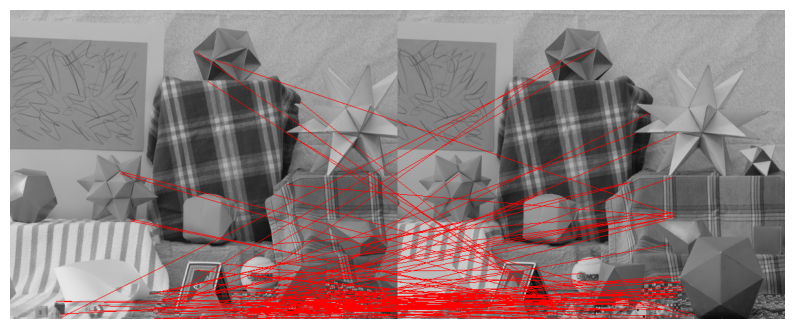

In [ ]:
print("Using Vanilla Corner Matching")
print("Descriptor similarity = SSD, No Y coordinate constraint, No ratio constraint")
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)

### **Q (3)** ###

**Use up to 4000 of the strongest corners (you can use fewer) in each image and use the matching only between corners that have approximately the same y-coordinate (up to a threshold).**

Using Y constraint for Corner Matching
Descriptor similarity = SSD, Using Y coordinate constraint, No ratio constraint


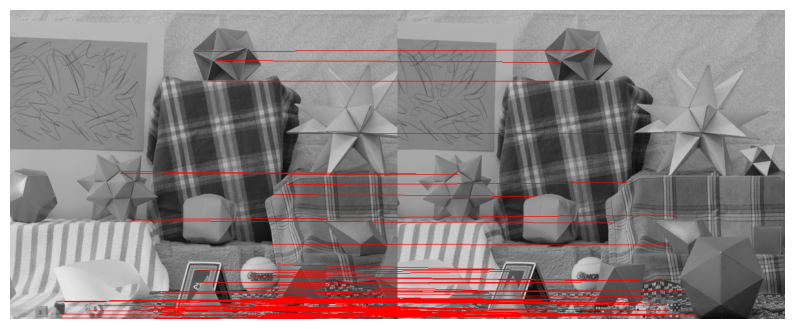

In [ ]:
print("Using Y constraint for Corner Matching")
same_y_flag = True
print("Descriptor similarity = SSD, Using Y coordinate constraint, No ratio constraint")
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)

### **Q (4)** ###

**Study the ratio for matching between the best and the second best match.**

Ratio constraint for 1st vs 2nd corner min eigan value
Descriptor similarity = SSD, No Y coordinate constraint, Using Ratio constraint
Ratio constraint = 1.00


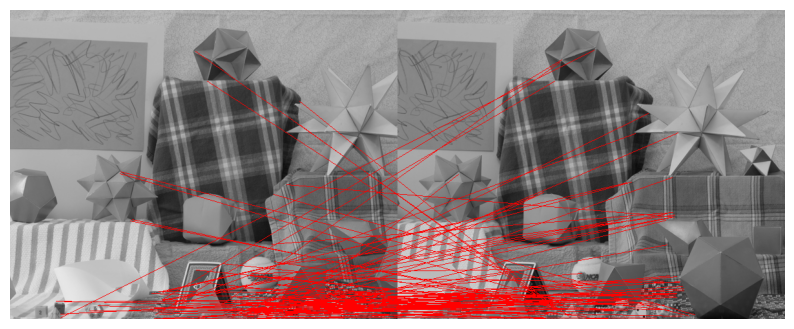

Descriptor similarity = SSD, No Y coordinate constraint, Using Ratio constraint
Ratio constraint = 1.3


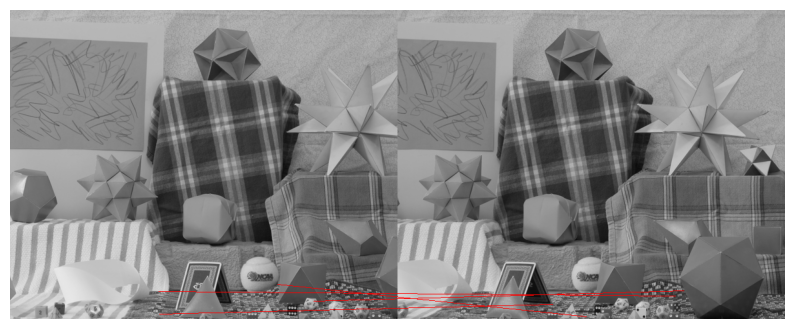

In [ ]:
print("Ratio constraint for 1st vs 2nd corner min eigan value")
ratio = True
same_y_flag = False
ratio_th = 1.00
print("Descriptor similarity = SSD, No Y coordinate constraint, Using Ratio constraint")
print("Ratio constraint = 1.00")
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)

ratio_th = 1.3
print("Descriptor similarity = SSD, No Y coordinate constraint, Using Ratio constraint")
print("Ratio constraint = 1.3")
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)

Increasing the matching ratio threshold to 1.3 results in the rejection of nearly all matches. This observation suggests that the majority of potential matches lack strong distinctiveness, indicating a low confidence in selecting the correct matchings. Consequently, there's often only a marginal difference between the best and second-best candidates, leading to frequent incorrect matchings.

### **Q (5)** ###

**Study the differences between the different descriptors and also the use of SSD or NCC.**

Part 5 - Comparing descriptors types (Intensity, Histogram, Gradient)
Descriptor similarity = SSD, Using Histogram as descriptors, No Y coordinate constraint, No ratio constraint


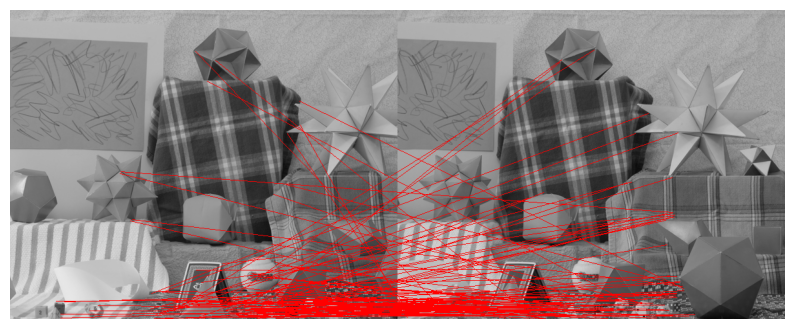

-------------------------------------------------------------------------
Descriptor similarity = SSD, Using gradients as descriptors, No Y coordinate constraint, No ratio constraint


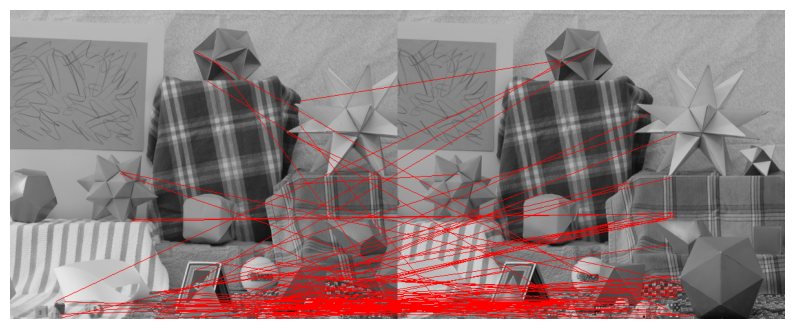

-------------------------------------------------------------------------
Descriptor similarity = SSD, Using Intensity as descriptors, No Y coordinate constraint, No ratio constraint


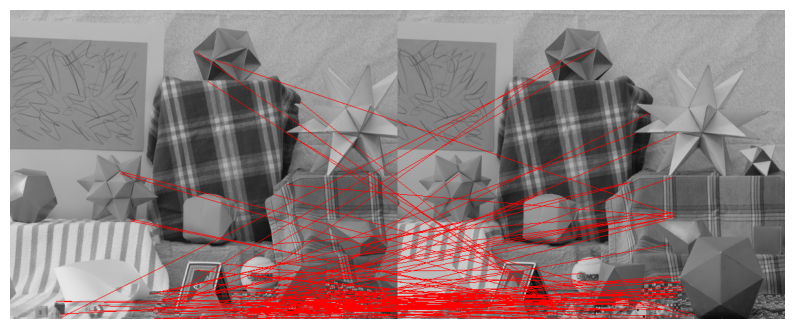

-------------------------------------------------------------------------
Part 5 - Comparing SSD vs NCC
Descriptor similarity = NCC, Using gradients as descriptors, No Y coordinate constraint, No ratio constraint


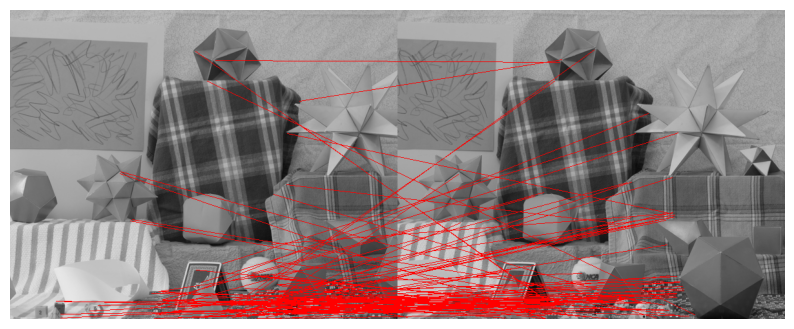

-------------------------------------------------------------------------
Descriptor similarity = SSD, Using gradients as descriptors, No Y coordinate constraint, No ratio constraint


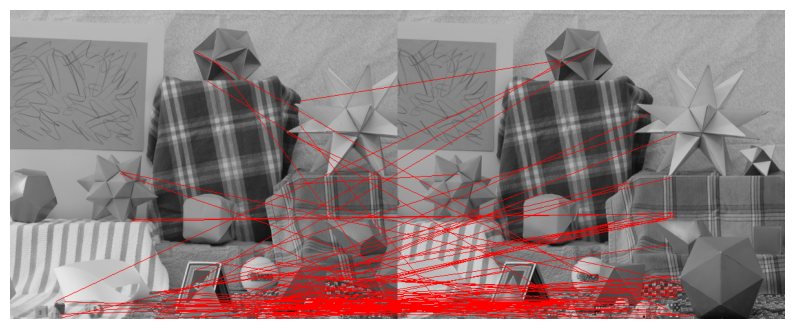

-------------------------------------------------------------------------


In [ ]:
print("Part 5 - Comparing descriptors types (Intensity, Histogram, Gradient)")
disc_type = "hist"
ratio = False
same_y_flag = False
print("Descriptor similarity = SSD, Using Histogram as descriptors, No Y coordinate constraint, No ratio constraint")
discreptor_matrix1, discreptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size, disc_type = disc_type)
corner_pairs = patch_machting_ratio(discreptor_matrix1, discreptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)
print("-------------------------------------------------------------------------")
print("Descriptor similarity = SSD, Using gradients as descriptors, No Y coordinate constraint, No ratio constraint")
disc_type = "grad"
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size, disc_type = disc_type)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)
print("-------------------------------------------------------------------------")
print("Descriptor similarity = SSD, Using Intensity as descriptors, No Y coordinate constraint, No ratio constraint")
disc_type = "intensity"
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size, disc_type = disc_type)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)
print("-------------------------------------------------------------------------")


print("Part 5 - Comparing SSD vs NCC")
print("Descriptor similarity = NCC, Using gradients as descriptors, No Y coordinate constraint, No ratio constraint")
disc_type = "grad"
same_y_flag = False
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size, disc_type = disc_type)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'NCC', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)
print("-------------------------------------------------------------------------")

print("Descriptor similarity = SSD, Using gradients as descriptors, No Y coordinate constraint, No ratio constraint")
disc_type = "grad"
same_y_flag = False
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size, disc_type = disc_type)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
display_matching(img1, img2, corner_pairs, same_y_flag , th = y_th)
print("-------------------------------------------------------------------------")

There is no clear similarity metric that outperforms the other between SSD to NCC, this was tested using both with and without Y constraint.
Similarly, there is almost no difference when using intensity/hist/grad as the descriptors. However, we observed a huge importance in using the y constraint, which leads to significantly better results.


### **Q (6)** ###

Identify incorrect pairs of matched points.\
   **Mark and display** for cases (2), (3), and (4) a pair of incorrectly matched points.\
   a. In which of the 3 cases are there more incorrect matches?\
   b. What may be the reason for the incorrect matches?

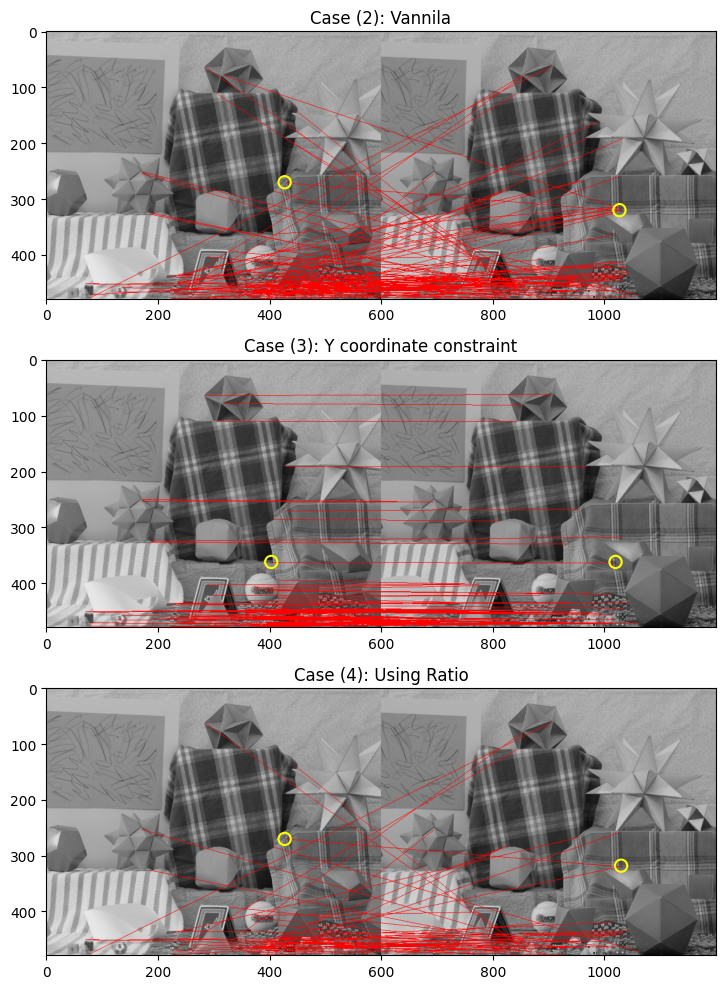

In [ ]:
same_y_flag = False
ratio = False
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
p2 = matching_images(img1, img2, corner_pairs, same_y_flag , th = y_th)

same_y_flag = True
descriptor_matrix1, descriptor_matrix2 = create_descriptors_matrix(corner_list_img1, corner_list_img2, img1, img2, patch_size = size)
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
p3 = matching_images(img1, img2, corner_pairs, same_y_flag , th = y_th)

ratio = True
same_y_flag = False
ratio_th = 1.05
corner_pairs = patch_machting_ratio(descriptor_matrix1, descriptor_matrix2, 'SSD', same_y_flag = same_y_flag, th = y_th, ratio = ratio, ratio_th = ratio_th)
p4 = matching_images(img1, img2, corner_pairs, same_y_flag , th = y_th)


titles = ["Case (2): Vannila",
          "Case (3): Y coordinate constraint",
          "Case (4): Using Ratio"]
wrong_matches = [(427, 270), (1027, 320), (403, 362), (1020, 362), (427, 270), (1030, 318)]

# Create a figure with subplots arranged in a column (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Ensure axes is an iterable list
axes = np.array(axes).reshape(-1)

# Iterate over the images and their corresponding titles
for idx, img in enumerate([p2, p3, p4]):
    axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(titles[idx])
    # axes[idx].axis('off')

    for point_idx in range(idx * 2, idx * 2 + 2):
        (x, y) = wrong_matches[point_idx]
        circle = plt.Circle((x, y), 11, color='yellow', fill=False, lw=1.5)
        axes[idx].add_patch(circle)

plt.tight_layout()
plt.show()

(6)
a. In which of the 3 cases are there more incorrect matches?

Among the three cases examined, the Case (2) exhibits the highest number of incorrect matches.

b. What may be the reason for the incorrect matches?

The increased incidence of incorrect matches in the first case can be attributed to the absence of filtering mechanisms that are present in the other cases.
Case 3: Given that the images are rectified, corresponding corners are expected to reside along the same y-values. This constraint effectively reduces false positives.
Case 4: In scenarios where multiple potential matches for a corner exist, this approach favors selections with higher certainty. By avoiding matching corners with ambiguous pairings, we minimize the likelihood of incorrect pairings.


### **Q (7)** ###

** In which regions of the scene were most of the reliable matches found? **

The majority of reliable matches were identified in the upper half of the image, characterized by reduced noise and pronounced descriptor attributes that enhance the efficacy of patch similarity evaluation.

# Part C

In this part you will compute the 3D structure from a pair of rectified images.


**The input:**\
    **a.** A pair of two rectified images, $im1$ and $im2$ (*view1.png and view5.png*).\
    **b.** A window size $(s_x,s_y$).\
    **c.** Disparity range $(d_{min},d_{max})$ (see below).

**The output:**\
**a.** A matrix, $D$ with the disparity map for the left image.\
**b.** Three matrices X, Y, Z with the x, y, z-coordinates of each pixel in the left image. Assign zero for pixels for which the disparity was not computed.

Note: all matrices $im1, im2, D, X, Y, Z$ have the same dimensions.

**Instructions:**
1. Read the two images view1.png and view5.png, and apply the functions to this pair of images.

   
2. Write a function that receives two rectified images, and compute dense matching along lines with the same $y-$coordinate.
    * You can use any of the descriptors from Part B. The patch size should be given as a parameter.
    * Use NCC for the similarity measure.
    * You can assume that you are given the range of disparities, $d_{min},d_{max}$ as an input. \
      For example, if  $(d_{min},d_{max})=(20,120)$ it follows that the corresponding point of  $(x,y)$ in the left image, is in the range $(x-120:x-20,y)$ in the right image.
    * Consider matching with and without order preseving.
    * List all parameters you use for your function.
    * Hints on efficient implementation is given below.
    
        
3. Write a function that computes the disparity based on (2).  
    * **Display** the disparity $D$ map as an image
   
  
4. Compute the depth map using the disparity.
    * Assume that scaled focal lengths ($f$ in the presentation) are $α_x=α_y=1$.
    * The distance between the cameras is 160mm.
    * Add to your disparity depth map the value 100, since images were cropped.
    * Display the disparity as an image.
   

4. Compute the matrices X,Y,Z
    * Present the object given by X,Y,Z using a 3D plot.


**Implementation**\
You can implement the computation of the similarity and the disparity directly by an exhaustive search. You can also use the idea from Part B. A more efficeint and elegant way is described below. You are welcome to try, but you do not have to.


General idea for the **vectorized solution** (you will need to fill in the gaps):
* Let $w$ and $h$ we the width and the height of the image respectively.
* First assume that the patch size is $1\times s_y$.
* Given two $1\times w$ rows, $r_1$ and $r_2$ which are corresponding rows of the two images. Compute the $w\times w$ matrix $R12=r_1^T r_2$. The values $R12(i,j)$ consists of the product of two pixels $r_1(i)\cdot r_2(j)$.
* Convolve $R12$ with the $s_y\times s_y$ identity matrix, $I_{s_y}$ : $Corr=I_{s_y}*R12$. The value $Corr(i,j)$ is the correlation of the $s_y$ 1D neighborhood of $r_1(i)$ and  $r_2(j)$.
* Think about how to normalize this correlation using the same idea. Hint, use the computation of $I_{s_y}*(r_1^Tr_1)$ and $I_{s_y}*(r_2^Tr_2)$.
* For a general patch size, $s_x\times s_y$, define $R$ to be 3D matrix of size $h\times w\times s_x$ and use 3D mask for the convolution.
* Up to here, we considered each row seperately, hence we need to loop over all rows of the images. There is a way to do it without looping, but not in this assignemnt :)


In [ ]:
def patch_NCC(patch1, patch2):
    u = patch1.flatten()
    v = patch2.flatten()
    u_norm = np.linalg.norm(u)
    v_norm = np.linalg.norm(v)
    u_normalized = u / u_norm if u_norm != 0 else u
    v_normalized = v / v_norm if v_norm != 0 else v
    return np.dot(u_normalized, v_normalized.T)

def patch_from_im2(im, p, size):
    half_size = size // 2
    start_x = max(p[0] - half_size, 0)
    end_x = min(p[0] + half_size + 1, im.shape[1])
    start_y = max(p[1] - half_size, 0)
    end_y = min(p[1] + half_size + 1, im.shape[0])
    patch = im[start_y:end_y, start_x:end_x]
    return patch

def dense_matching_ncc(im1, im2, patch_size, dmin, dmax, preserve_order=False):
    """
    Compute dense matching using Normalized Cross Correlation (NCC).
    im1 (np.ndarray): The left rectified image.
    im2 (np.ndarray): The right rectified image.
    patch_size (tuple of int): The size of the window (sx, sy) to use for patch comparison.
    dmin (int): The minimum disparity.
    dmax (int): The maximum disparity.
    preserve_order (bool): Whether to preserve the order of matches.

    Returns:
    np.ndarray: A disparity map for the left image.
    """


    disparity_map = np.zeros_like(im1, dtype=np.float32)
    half_patch_size = patch_size//2

    for y in range(half_patch_size, im1.shape[0] - half_patch_size + 1):
        if y%100 == 0:
          print(f"Finished Computing row {y} of {im1.shape[0]}")

        max_disparity_allowed = dmax
        for x in range(half_patch_size, im1.shape[1] - half_patch_size ):
            best_disparity = 0
            best_ncc_score = -1
            patch_left = patch_from_im2(im1,(x,y), patch_size)
            for d in range(dmin, min(max_disparity_allowed, dmax) + 1):

              # Check left and right bounds in the right image
              if x - d < half_patch_size or x - d > im2.shape[1] - half_patch_size:
                continue

              patch_right = patch_from_im2(im2, (x - d, y), patch_size)
              ncc_score = patch_NCC(patch_left, patch_right)
              if ncc_score > best_ncc_score:
                best_ncc_score = ncc_score
                best_disparity = d

            disparity_map[y, x] = best_disparity

            # Update max_disparity_allowed only if best_disparity is above a certain threshold to avoid left side of image with 0 values
            if preserve_order and best_disparity > (dmin + 5):
                max_disparity_allowed = best_disparity

    return disparity_map

def compute_XYZ(disparity_map, baseline=160, disparity_offset=100):
    """
    Computes the X, Y, Z matrices from a disparity map.

    Parameters:
    disparity_map (np.ndarray): The disparity map for the left image.
    baseline (float): The distance between the COP's in mm.
    disparity_offset (int): The offset to add to the disparity values (due to cropping)

    Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray]: Matrices X, Y, Z representing the 3D coordinates.
    """
    Z =  baseline / (disparity_map + disparity_offset)
    h, w = D.shape
    X_grid, Y_grid = np.meshgrid(np.arange(w), np.arange(h))

    # Compute real-world X, Y coordinates
    X = (X_grid - w / 2) * Z
    Y = (Y_grid - h / 2) * Z
    return X, Y, Z

from mpl_toolkits.mplot3d import Axes3D

def plot_3D(X, Y, Z):
    """
    Plots the 3D points represented by the X, Y, Z matrices.

    Parameters:
    X, Y, Z (np.ndarray): Matrices representing the 3D coordinates.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X.flatten(), Z.flatten(), -Y.flatten(), marker='.', s=0.1, alpha=0.2)   # Changed axes to align with image
    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    plt.title('3D Plot of XYZ Coordinates')
    plt.show()

In [ ]:
img1 = cv2.imread('/content/view1.tif', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/view5.tif', cv2.IMREAD_GRAYSCALE)

In [ ]:
# Takes about 10 mins
D = dense_matching_ncc(img1, img2, patch_size=3, dmin=20, dmax=120, preserve_order=False)

Finished Computing row 100 of 555
Finished Computing row 200 of 555
Finished Computing row 300 of 555
Finished Computing row 400 of 555
Finished Computing row 500 of 555


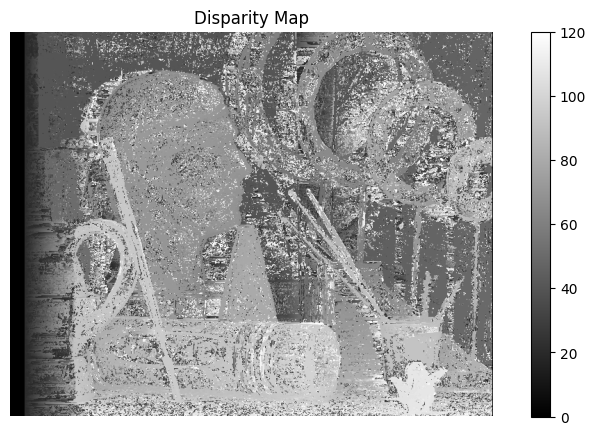

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(D, cmap='gray')
plt.colorbar()
plt.title("Disparity Map")
plt.axis('off')
plt.show()

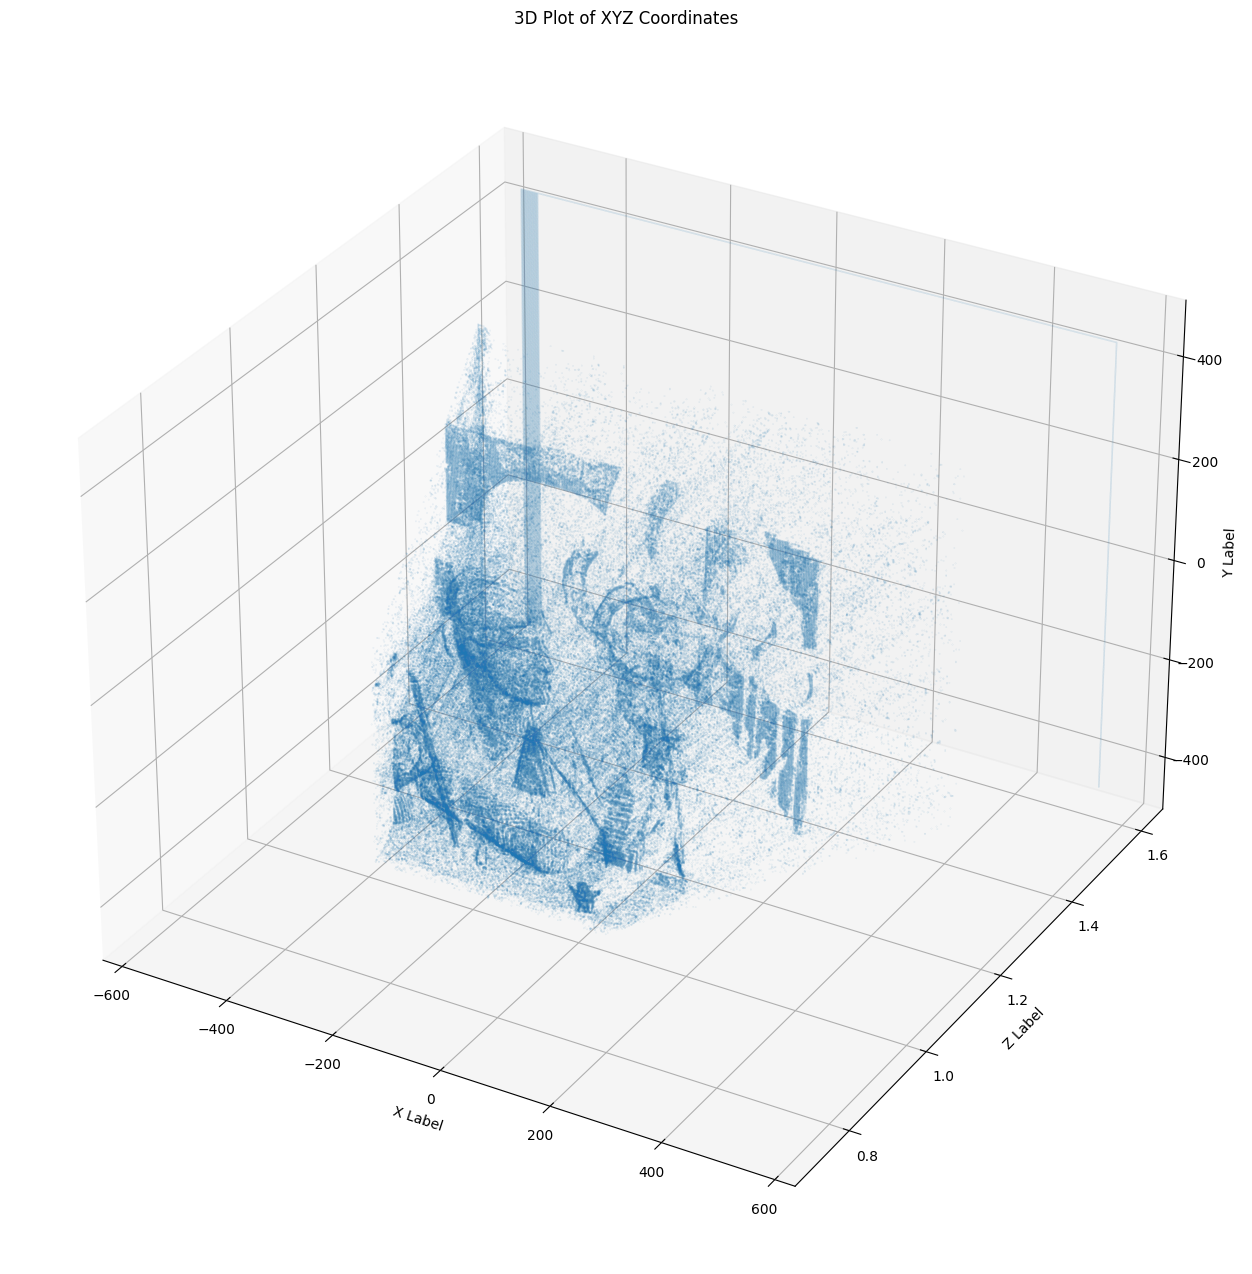

In [ ]:
X, Y, Z = compute_XYZ(D, baseline=160, disparity_offset=100)
plot_3D(X, Y, Z)